<br>

Hongzhang "Steve" Shao

Work of Spring 2021

<br>

In [1]:
import numpy as np 
import cvxpy as cp 
import pandas as pd 

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCS']


<br>

# An Analysis of Pickup Time Dynamic on Continuous Space

<br>

<br>

# A CTMC Model of Ride-sharing Systems with Pickup Time Dynamic

<br>

In [2]:
# ==================== DATA INPUT - FIVE REGIONS ==================== # 

# inverse of mean travel times (in hours) between regions
mu0 = 1 / np.array([[0.25, 0.25, 0.25, 0.25, 0.25], 
                    [0.25, 0.25, 0.25, 0.25, 0.25], 
                    [0.25, 0.25, 0.25, 0.25, 0.25], 
                    [0.25, 0.25, 0.25, 0.25, 0.25], 
                    [0.25, 0.25, 0.25, 0.25, 0.25]])

# number of passenger arrivals (per hour, per car)
lmd0 = np.array([[0.01, 0.01, 0.01, 0.01, 0.01], 
                 [0.01, 0.01, 0.01, 0.01, 0.01], 
                 [0.01, 0.01, 0.01, 0.01, 0.01], 
                 [0.01, 0.01, 0.01, 0.01, 0.01], 
                 [0.01, 0.01, 0.01, 0.01, 0.01]])


# ==================== DATA INPUT - FIVE REGIONS ==================== # 

# A simplified model of a city that consists of 5 regions: 
# [S1, S2, S3, M, D]. 
# They are: a downtown area D, a midtown area M, 
# and three suburban areas S1, S2, S3. 
# The downtown area represents a central business district, 
# where many people work but few people live. 
# Midtown represents a region with restaurants and night-life, 
# where people visit after work. 
# The suburb regions are residential areas, 
# and do not have as many entertainment options as midtown. 

# ---------- scenario one ---------- # 

# A rush hour as people go home from work. 
# Most of the traffic originates in downtown, 
# and flows into the suburbs as people go home after work. 

# inverse of mean travel times (in hours) between regions
mu1 = 1 / np.array([[0.15, 0.25, 1.25, 0.2, 0.4], 
                    [0.25, 0.10, 1.1, 0.1, 0.3], 
                    [1.25, 1.1, 0.1, 1, 0.65], 
                    [0.25, 0.15, 1, 0.15, 0.25], 
                    [0.5, 0.4, 0.75, 0.25, 0.2]])

# number of passenger arrivals (per hour, per car)
lmd1 = np.array([[0.6, 0.1, 0, 0.3, 0],
                 [0.1, 0.6, 0, 0.3, 0],
                 [0, 0, 0.7, 0.3, 0],
                 [0.2, 0.2, 0.2, 0.2, 0.2],
                 [0.3, 0.3, 0.3, 0.1, 0]])

lmd1 = np.transpose(np.array([[0.108, 0.108, 0.108, 0.108, 1.08]])) * lmd1 + 0.01


# ---------- scenario two ---------- # 

# Most of the traffic is headed into midtown, 
# as people go out in the evening to restaurants and for entertainment. 

# inverse of mean travel times (in hours) between regions
mu2 = 1 / np.array([[0.15, 0.25, 1.25, 0.2, 0.4], 
                    [0.25, 0.10, 1.1, 0.1, 0.3], 
                    [1.25, 1.1, 0.1, 1, 0.65], 
                    [0.2, 0.1, 1, 0.15, 0.25], 
                    [0.4, 0.3, 0.65, 0.25, 0.2]])

# number of passenger arrivals (per hour, per car)
lmd2 = np.array([[0.1, 0, 0, 0.9, 0], 
                 [0, 0.1, 0, 0.9, 0], 
                 [0, 0, 0.1, 0.9, 0], 
                 [0.05, 0.05, 0.05, 0.8, 0.05], 
                 [0, 0, 0, 0.9, 0.1]])

lmd2 = np.transpose(np.array([[0.72, 0.48, 0.48, 0.48, 0.12]])) * lmd2 + 0.01


# ---------- scenario three ---------- # 

# A rush hour as people go home from work. 
# Most of the traffic originates in downtown, 
# and flows into the suburbs as people go home after work. 

# inverse of mean travel times (in hours) between regions
mu3 = 1 / np.array([[0.15, 0.25, 1.25, 0.2, 0.4], 
                    [0.25, 0.10, 1.1, 0.1, 0.3], 
                    [1.25, 1.1, 0.1, 1, 0.65], 
                    [0.2, 0.1, 1, 0.15, 0.25], 
                    [0.4, 0.3, 0.65, 0.25, 0.2]])

# number of passenger arrivals (per hour, per car)
lmd3 = np.array([[0.9, 0.05, 0, 0.05, 0], 
                 [0.05, 0.9, 0, 0.05, 0], 
                 [0, 0, 0.9, 0.1, 0], 
                 [0.3, 0.3, 0.3, 0.05, 0.05], 
                 [0, 0, 0, 0.1, 0.9]])

lmd3 = np.transpose(np.array([[0.12, 0.12, 0.12, 1.32, 0.12]])) * lmd3 + 0.01


# ---------- testing scenario ---------- # 

lmd4 = np.array([[0, 1, 1, 1, 1], 
                 [0, 0, 0, 0, 0], 
                 [0, 0, 0, 0, 0], 
                 [0, 0, 0, 0, 0], 
                 [0, 0, 0, 0, 0]])

<br>

## Network Setup and States

<br>


In [3]:
class Network:

  def __init__(self, lmd, mu, N = 90, K = 3, expanded = False): 
    # inputs and dimensions
    self.expanded = expanded
    self.lmd = N * lmd
    self.mu = mu

    self.Z = mu.shape[0]
    self.N = N
    self.K = K

    # initialize parameters
    self.omega = 4
    self.delta = 1
    self.theta = 1

    self.nu = 10 / (np.arange(K) + 1)

    self.eta = 5
    self.beta = 1 / self.eta
    self.alpha = []
    for k in range(self.K): 
      self.alpha.append((10 + 20 / self.mu - 20 / self.nu[k]) / self.eta)

    # initialize states
    self.At = np.random.multinomial(self.N, [1.0 / self.Z] * self.Z)
    self.Dt = []
    for k in range(self.K): 
      self.Dt.append(np.zeros([self.Z, self.Z]))
    self.Et = np.zeros([self.Z, self.Z])
    self.Ft = np.zeros([self.Z, self.Z])

    # initialize probabilities
    self.Qt = np.zeros([self.Z, self.K+1])
    self.update_pickup_prob()


  def update_pickup_prob(self): 
    for k in np.arange(self.K) + 1: 
      if self.expanded: 
        self.Qt[:,k-1] = np.exp(- ((k * self.delta - self.delta) ** 2) 
                          * self.omega * (self.At + np.sum(self.Et, axis=1)) / (self.theta * self.N))
        self.Qt[:,k-1] = self.Qt[:,k-1] - np.exp(- ((k * self.delta) ** 2) 
                          * self.omega * (self.At + np.sum(self.Et, axis=1)) / (self.theta * self.N))
      else:
        self.Qt[:,k-1] = np.exp(- ((k * self.delta - self.delta) ** 2) 
                          * self.omega * self.At / (self.theta * self.N))
        self.Qt[:,k-1] = self.Qt[:,k-1] - np.exp(- ((k * self.delta) ** 2) 
                          * self.omega * self.At / (self.theta * self.N))
    self.Qt[:,k] = 1 - np.sum(self.Qt[:,0:k], axis=1)



# for debugging
my_model = Network(lmd = lmd1, mu = mu1)
# print(my_model.alpha)
# print(my_model.beta)
print(my_model.nu)
print(my_model.Qt)

[10.          5.          3.33333333]
[[4.38856031e-01 4.61992946e-01 9.36344581e-02 5.51656442e-03]
 [5.88887709e-01 3.82546790e-01 2.82300382e-02 3.35462628e-04]
 [6.70807012e-01 3.17449359e-01 1.16982285e-02 4.53999298e-05]
 [4.86582881e-01 4.43933668e-01 6.70046990e-02 2.47875218e-03]
 [5.30250430e-01 4.21056679e-01 4.75791165e-02 1.11377515e-03]]


<br>

## Actions

<br>


In [4]:
# ==================== POLICY - FIVE REGIONS ==================== # 

# ---------- policy one ---------- # 

# all customer accepts offer w.p.1
p1 = np.array([[1, 1, 1, 1, 1], 
               [1, 1, 1, 1, 1], 
               [1, 1, 1, 1, 1], 
               [1, 1, 1, 1, 1], 
               [1, 1, 1, 1, 1]])
p1 = [p1, p1, p1]

# no empty repositioning
q1 = np.diag(np.array([1, 1, 1, 1, 1]))


# ---------- policy two ---------- # 

# all customer accepts offer w.p.1
p2 = np.array([[1, 1, 1, 1, 1], 
               [1, 1, 1, 1, 1], 
               [1, 1, 1, 1, 1], 
               [1, 1, 1, 1, 1], 
               [1, 1, 1, 1, 1]])
p2 = [p2, p2, p2]

# empty repositioning with equal probability
q2 = np.array([[0.2, 0.2, 0.2, 0.2, 0.2], 
               [0.2, 0.2, 0.2, 0.2, 0.2], 
               [0.2, 0.2, 0.2, 0.2, 0.2], 
               [0.2, 0.2, 0.2, 0.2, 0.2], 
               [0.2, 0.2, 0.2, 0.2, 0.2]])


# ---------- policy three ---------- # 

# all customer accepts offer w.p.1
p3 = np.array([[1, 1, 1, 1, 1], 
               [1, 1, 1, 1, 1], 
               [1, 1, 1, 1, 1], 
               [1, 1, 1, 1, 1], 
               [1, 1, 1, 1, 1]])
p3 = [p3, p3, p3]

# empty repositioning more towards midtown
q3 = np.array([[0.1, 0.1, 0.1, 0.6, 0.1], 
               [0.1, 0.1, 0.1, 0.6, 0.1], 
               [0.1, 0.1, 0.1, 0.6, 0.1], 
               [0.1, 0.1, 0.1, 0.6, 0.1], 
               [0.1, 0.1, 0.1, 0.6, 0.1]])

<br>

## Transition Rates and CTMC Model

<br>

In [5]:
class CTMC(Network):

  def __init__(self, p, q, lmd, mu, 
               N = 200, K = 3, static_policy = True, expanded = False):
    super().__init__(lmd = lmd, mu = mu, N = N, K = K, expanded = expanded)
    # policies
    self.p = p 
    self.q = q 
    self.y = self.q * 0

    # system time
    self.t = 0

    # policy setup
    self.static_policy = static_policy

    # for testing
    self.num_ride = 0
    self.num_ride_accepted = 0
  

  def update(self):
    # next event
    self.update_pickup_prob()
    event = self.__next_event()

    # update states
    if event == 0: 
      i, j, k = self.__trans_dispatched()
    if event == 1: 
      i, j, k = self.__trans_picked_up()
    if event == 2: 
      i, j = self.__trans_delivered()
    if event == 3: 
      i, j = self.__trans_relocated()

    # generate action from static policy
    if self.static_policy: 
      if event == 2 or event == 3: 
        i_prime = np.random.choice(range(self.Z), size=1, p = self.q[j,])[0]
        self.y = self.q * 0
        if i_prime != j: 
          self.y[j,i_prime] = 1

    # execute action
    self.At -= np.sum(self.y, axis=1).astype(np.int)
    self.Et += self.y 
    self.y = self.q * 0
  
  
  def __next_event(self): 
    # holder of rates
    rates = np.array([0, 0, 0, 0])

    # overall rate of passenger arrival
    rates[0] = np.sum(self.lmd)
    # overall rate of passenger pickup
    for k in range(self.K): 
      rates[1] = rates[1] + np.sum(self.Dt[k]) * self.nu[k]
    # overall rate of passenger delivery
    rates[2] = np.sum(self.Ft * self.mu)
    # overall rate of car relocating
    rates[3] = np.sum(self.Et * self.mu)
    # update system time
    self.t = self.t + np.random.exponential(1 / np.sum(rates))
    # return results
    event = np.random.choice(range(4), size=1, p = rates/np.sum(rates))[0]
    return event


  def __trans_dispatched(self): 
    # prepare the probability vector
    prob = self.lmd.flatten() 
    prob = prob / np.sum(prob)

    # sample a ride
    i = np.random.choice(range(self.Z ** 2), size=1, p = prob)[0]
    j = i % self.Z
    i = i // self.Z

    # sample a pickup queue
    k = np.random.choice(range(self.K+1), size=1, p = self.Qt[i,])[0]
    self.num_ride += 1

    # update states
    if self.At[i] > 0: 
      if k < self.K:
        accepted = np.random.choice([True, False], p = (self.p[k][i,j], 1-self.p[k][i,j]))
        if accepted: 
          self.num_ride_accepted += 1
          self.At[i] -= 1
          self.Dt[k][i,j] += 1

    # collect indices
    return i, j, k

  
  def __trans_picked_up(self): 
    # generate rates for different pickup queue
    prob_k = np.zeros(self.K)
    for k in range(self.K): 
      prob_k[k] = np.sum(self.Dt[k]) * self.nu[k]
    
    # sample a pickup queue
    prob_k = prob_k / np.sum(prob_k)
    k = np.random.choice(range(self.K), size=1, p = prob_k)[0]

    # prepare the probability vector
    prob = self.Dt[k].flatten() 
    prob = prob / np.sum(prob)

    # sample a ride
    i = np.random.choice(range(self.Z ** 2), size=1, p = prob)[0]
    j = i % self.Z
    i = i // self.Z

    # update states
    if self.Dt[k][i,j] > 0: 
      self.Dt[k][i,j] -= 1
      self.Ft[i,j] += 1  

    # collect indices
    return i, j, k

  
  def __trans_delivered(self): 
    # prepare the probability vector
    prob = self.Ft * self.mu
    prob = prob.flatten() 
    prob = prob / np.sum(prob)

    # sample a ride
    i = np.random.choice(range(self.Z ** 2), size=1, p = prob)[0]
    j = i % self.Z
    i = i // self.Z

    # update states
    if self.Ft[i,j] > 0: 
      self.Ft[i,j] -= 1
      self.At[j] += 1

    # collect indices
    return i, j

  
  def __trans_relocated(self): 
    # prepare the probability vector
    prob = self.Et * self.mu
    prob = prob.flatten() 
    prob = prob / np.sum(prob)

    # sample a ride
    i = np.random.choice(range(self.Z ** 2), size=1, p = prob)[0]
    j = i % self.Z
    i = i // self.Z

    # update states
    if self.Et[i,j] > 0: 
      self.Et[i,j] -= 1
      self.At[j] += 1

    # collect indices
    return i, j



# for debugging
np.random.seed(1)
my_model = CTMC(p = p3, q = q3, lmd = lmd3, mu = mu3)
for l in range(100): 
  my_model.update()
  if l % 100 == 0: 
    print()

<br>

# Static Policy

<br>

<br>

## Fluid-based Optimization Problem

<br>

In [6]:
class CTMC_Solver: 

  def __init__(self, model, expanded = False): 
    # get input
    self.expanded = expanded
    self.model = model
    self.lmd = self.model.lmd / self.model.N

    # initialize optimization problem
    self.__init_problem()
    self.__add_flow_constraints()
    self.__add_pickup_constraints()
    self.__add_choice_constraints()
    self.__add_cardinality_constraints()


  def __init_problem(self): 
    # initialize variables
    self.a = cp.Variable(self.model.Z)
    self.d = []
    for k in range(self.model.K): 
      self.d.append(cp.Variable((self.model.Z, self.model.Z)))
    self.e = cp.Variable((self.model.Z, self.model.Z))
    self.f = cp.Variable((self.model.Z, self.model.Z))

    self.u = []
    for k in range(self.model.K): 
      self.u.append(cp.Variable((self.model.Z, self.model.Z)))
    self.q = cp.Variable((self.model.Z, self.model.K))

    # set objective
    self.revenue = 0
    for k in range(self.model.K): 
      self.revenue += cp.multiply(self.model.nu[k], self.u[k])
    self.revenue = cp.sum(self.revenue)
    # initialize constraints
    self.constraints = []


  def __add_flow_constraints(self): 
    # customer inflow (pick-up to delivery)
    self.flow_pickup = 0
    for k in range(self.model.K): 
      self.flow_pickup += cp.multiply(self.model.nu[k], self.d[k])
    self.flow_delivery = cp.multiply(self.model.mu, self.f)
    self.constraints += [self.flow_pickup == self.flow_delivery]

    # network constraints (relocation and node balance)
    self.flow_f_in = cp.sum(cp.multiply(self.model.mu, self.f), axis=0)
    self.flow_f_out = cp.sum(cp.multiply(self.model.mu, self.f), axis=1)

    self.flow_e_in = cp.sum(cp.multiply(self.model.mu, self.e), axis=0)
    self.flow_e_out = cp.sum(cp.multiply(self.model.mu, self.e), axis=1)
    
    self.constraints += [self.flow_f_in + self.flow_e_in == 
                         self.flow_f_out + self.flow_e_out]


  def __add_pickup_constraints(self): 
    for k in range(self.model.K): 
      self.availability = ((k+1) * self.model.delta) ** 2
      if self.expanded: 
        self.availability = self.model.omega * self.availability * (self.a + cp.sum(self.e, axis=1)) / self.model.theta
      else: 
        self.availability = self.model.omega * self.availability * self.a / self.model.theta
      self.availability = 1 - cp.exp(-self.availability)
      self.constraints += [cp.sum(self.q[:,0:(k+1)], axis=1) <= self.availability]
      # self.constraints += [cp.sum(self.q[:,0:(k+1)], axis=1) <= 1]


  def __add_choice_constraints(self): 
    for k in range(self.model.K):  
      # model the multinomial logit choice model as conic constraints
      for i in range(self.model.Z): 
        for j in range(self.model.Z): 
          self.constraints += [cp.constraints.exponential.ExpCone(
              self.model.beta * self.model.nu[k] * self.u[k][i,j]
              - self.model.alpha[k][i,j] * self.model.nu[k] * self.d[k][i,j], 
              self.model.nu[k] * self.d[k][i,j], 
              self.q[i,k] * self.lmd[i,j] 
              - self.model.nu[k] * self.d[k][i,j]
          )] 
  

  def __add_cardinality_constraints(self):
    # non-negative constaints
    self.constraints += [self.a >= 0]
    for k in range(self.model.K): 
      self.constraints += [self.d[k] >= 0]
    self.constraints += [self.e >= 0]
    self.constraints += [self.f >= 0]

    self.constraints += [self.q >= 0]

    # scale number of cars to one
    self.n = cp.sum(self.a)
    for k in range(self.model.K): 
      self.n += cp.sum(self.d[k])
    self.n += cp.sum(self.e) 
    self.n += cp.sum(self.f)

    self.constraints += [self.n == 1]

  
  def solve(self): 
    # solve the conic program
    self.problem = cp.Problem(cp.Maximize(self.revenue), self.constraints)
    self.problem.solve(solver='ECOS') # ECOS or SCS

    # compute p
    self.p_opt = []
    for k in range(self.model.K): 
      self.p_opt.append(self.e.value * 0)
      # update choice probability
      for i in range(self.model.Z): 
        for j in range(self.model.Z): 
          self.p_opt[k][i,j] = self.q[i,k].value * self.lmd[i,j]
          if self.p_opt[k][i,j] > 1e-7:
            self.p_opt[k][i,j] = self.model.nu[k] * self.d[k][i,j].value / self.p_opt[k][i,j]
    
    # compute x 
    self.x_opt = []
    for k in range(self.model.K): 
      temp = cp.multiply(self.u[k], 1 / self.d[k]).value
      self.x_opt.append(temp)

    # compute q
    self.q_opt = self.e.value * 0
    for i in range(self.model.Z): 
      # if there is (almost) no inflow, then assume there is no relocating
      if self.flow_f_in.value[i] < 1e-7:
        self.q_opt[i,:] = 0
      else: 
        self.q_opt[i,:] = cp.multiply(self.model.mu, self.e).value[i,:]
        self.q_opt[i,:] = self.q_opt[i,:] / (self.flow_e_in.value[i] + self.flow_f_in.value[i])
      self.q_opt = np.maximum(self.q_opt, 0)
      # update probability of staying
      self.q_opt[i,i] = 1 - sum(self.q_opt[i,:]) + self.q_opt[i,i]



# debugging
my_model = CTMC(p = p3, q = q3, lmd = lmd3, mu = mu3, N = 200)
my_solver = CTMC_Solver(model = my_model)
my_solver.solve()

# print results
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

# print('\n - debugging:')
print(my_solver.lmd)
# print(my_solver.a.value)

print('\n - total revenue:')
print(my_solver.revenue.value)
print('\n - number of idle cars:')
print(my_solver.a.value)
print('\n - full car flow:')
print(cp.multiply(my_solver.model.mu, my_solver.f).value)
print('\n - empty car flow:')
print(cp.multiply(my_solver.model.mu, my_solver.e).value)

[[0.118 0.016 0.01  0.016 0.01 ]
 [0.016 0.118 0.01  0.016 0.01 ]
 [0.01  0.01  0.118 0.022 0.01 ]
 [0.406 0.406 0.406 0.076 0.076]
 [0.01  0.01  0.01  0.022 0.118]]

 - total revenue:
12.94925346698478

 - number of idle cars:
[0.03451 0.03022 0.04972 0.13689 0.03512]

 - full car flow:
[[0.03225 0.00501 0.00425 0.00504 0.00328]
 [0.00421 0.02848 0.00358 0.00409 0.00268]
 [0.00621 0.00611 0.03675 0.01334 0.00537]
 [0.16234 0.15637 0.2138  0.03218 0.03094]
 [0.00345 0.00335 0.00306 0.00742 0.03408]]

 - empty car flow:
[[ 0.       0.       0.       0.15863  0.     ]
 [ 0.       0.       0.       0.15628  0.     ]
 [ 0.       0.       0.       0.       0.19366]
 [ 0.       0.      -0.       0.       0.     ]
 [ 0.       0.       0.       0.21865  0.     ]]


<br>

Check results: 

<br>

In [7]:
print('\n - availability:')
print(my_solver.a.value)
print('\n - optimal q:')
print(my_solver.q_opt)
print('\n - optimal p:')
for k in range(my_model.K): 
  print(my_solver.p_opt[k])
print('\n - optimal x:')
for k in range(my_model.K): 
  print(my_solver.x_opt[k])


 - availability:
[0.03451 0.03022 0.04972 0.13689 0.03512]

 - optimal q:
[[0.23903 0.      0.      0.76097 0.     ]
 [0.      0.21591 0.      0.78409 0.     ]
 [0.      0.      0.25927 0.      0.74073]
 [0.      0.      0.      1.      0.     ]
 [0.      0.      0.      0.80979 0.19021]]

 - optimal p:
[[0.47834 0.52794 0.65722 0.53051 0.54594]
 [0.49174 0.4617  0.61284 0.48118 0.49832]
 [0.77333 0.76385 0.4617  0.75934 0.69173]
 [0.45583 0.44162 0.57363 0.47834 0.46283]
 [0.56223 0.55082 0.51592 0.55324 0.49451]]
[[0.40304 0.45877 0.61082 0.4617  0.47944]
 [0.41791 0.38481 0.55786 0.40618 0.42526]
 [0.74964 0.73841 0.38481 0.73306 0.65222]
 [0.37843 0.36314 0.51163 0.40304 0.38603]
 [0.49832 0.48508 0.44509 0.48788 0.421  ]]
[[0.32261 0.38162 0.55547 0.38481 0.40425]
 [0.33805 0.30399 0.49324 0.32585 0.34576]
 [0.72152 0.70814 0.30399 0.70174 0.60484]
 [0.29757 0.28234 0.44024 0.32261 0.30523]
 [0.42526 0.4105  0.36685 0.41361 0.34128]]

 - optimal x:
[[11.43349 12.44063 29.74559 11

<br>

## Simulator of the CTMC Model

<br>

In [8]:
class Simulator: 

  def __init__(self, model, x, num_events=10000, seed=123): 
    # ---------- input ---------- # 

    # setup
    self.seed = seed
    self.model = model
    self.num_events = num_events
    self.x = x

    # data holder
    self.A = []
    self.D = [[] for k in range(self.model.K)]
    self.E = []
    self.F = []
    
    self.D_count = [[] for k in range(self.model.K)]
    self.Q = []
    self.t = []
  

  def run(self):
    # set seed
    np.random.seed(self.seed)

    # initializing simulation
    for iter in range(self.num_events): 
      self.model.update()
      # record data
      self.t += [self.model.t]
      self.A += [self.model.At.copy()]
      for k in range(self.model.K): 
        self.D[k] += [self.model.Dt[k].copy()]
      self.E += [self.model.Et.copy()]
      self.F += [self.model.Ft.copy()]
      self.Q += [self.model.Qt.copy()]

    # start recording profits
    D_temp = np.copy(self.model.Dt)
    t_temp = np.copy(self.model.t)
    self.D_count = np.copy(self.model.Dt)
    for k in range(self.model.K): 
      self.D_count[k] *= 0

    # run simulation
    for iter in range(self.num_events): 
      self.model.update()
      # record data
      self.t += [self.model.t]
      self.A += [self.model.At.copy()]
      for k in range(self.model.K): 
        self.D[k] += [self.model.Dt[k].copy()]
      self.E += [self.model.Et.copy()]
      self.F += [self.model.Ft.copy()]
      self.Q += [self.model.Qt.copy()]
      # record sales
      for k in range(self.model.K): 
        self.D_count[k] += np.maximum(self.model.Dt[k] - D_temp[k], 0)
        D_temp[k] = self.model.Dt[k].copy()

    # compute average revenue per car per hour
    self.avg_revenue = np.sum(self.D_count * self.x)
    self.avg_revenue = self.avg_revenue / (self.model.t - t_temp)
    self.avg_revenue = self.avg_revenue / self.model.N



# setup model
my_model_init = CTMC(p = p3, q = q3, lmd = lmd3, mu = mu3, N = 200)
my_solver = CTMC_Solver(model = my_model_init)
my_solver.solve()

# run simulation
my_model = CTMC(p = my_solver.p_opt, q = my_solver.q_opt, lmd = lmd3, mu = mu3, N = 200)
my_simulator = Simulator(model = my_model, 
                         x = my_solver.x_opt, 
                         num_events = 1000)
my_simulator.run()

print(my_simulator.avg_revenue)

11.535309509654342


<br>

# A State-dependent Policy

<br>

In [9]:
class ApproxMDP: 

  def __init__(self, model, solver, num_events=10000, seed=123): 
    # ---------- input ---------- # 

    # setup
    self.seed = seed
    self.model = model
    self.solver = solver
    self.num_events = num_events

    self.model.static_policy = False
    self.tau = 100
    self.x = self.solver.x_opt

    # data holder
    self.A = []
    self.D = [[] for k in range(self.model.K)]
    self.E = []
    self.F = []
    
    self.D_count = [[] for k in range(self.model.K)]
    self.Q = []
    self.t = []


  def __get_action(self): 
    # origin
    a_orig = self.model.At.copy() / self.model.N
    d_orig = [[] for k in range(self.model.K)]
    for k in range(self.model.K):
      d_orig[k] = self.model.Dt[k].copy() / self.model.N
    e_orig = self.model.Et.copy() / self.model.N
    f_orig = self.model.Ft.copy() / self.model.N

    # destination
    a_dest = self.solver.a.value.copy()
    d_dest = d_orig.copy()
    for k in range(self.model.K):
      d_dest[k] = self.solver.d[k].value.copy()
    e_dest = self.solver.e.value.copy()
    f_dest = self.solver.f.value.copy()

    # initialize variables
    y = cp.Variable((self.model.Z, self.model.Z))
    d_in = []
    d_out = []
    for k in range(self.model.K): 
      d_in.append(cp.Variable((self.model.Z, self.model.Z)))
      d_out.append(cp.Variable((self.model.Z, self.model.Z)))
    e_in = cp.Variable((self.model.Z, self.model.Z))
    e_out = cp.Variable((self.model.Z, self.model.Z))
    f_out = cp.Variable((self.model.Z, self.model.Z))

    # initialize objective
    flow = cp.sum(e_in / self.tau)
    flow += cp.sum(e_out / self.model.mu)
    flow += cp.sum(f_out / self.model.mu)
    for k in range(self.model.K): 
      flow += cp.sum(d_out[k] / self.model.nu[k])
      flow += cp.sum(d_in[k] / (self.model.lmd * self.solver.p_opt[k] * self.solver.q.value[:,k:(k+1)]))

    # initialize constraints
    constraints = []

    # node balance for a
    a_diff = cp.sum(f_out + e_out, axis=0) - cp.sum(y + e_in, axis=1)
    for k in range(self.model.K): 
      a_diff -= cp.sum(d_in[k], axis=1)
    constraints += [a_diff == a_dest - a_orig]

    # node balance for d
    for k in range(self.model.K): 
      constraints += [d_in[k] - d_out[k] == d_dest[k] - d_orig[k]]
    # node balance for e
    constraints += [y + e_in - e_out == e_dest - e_orig]
    # node balance for f
    f_diff = - f_out
    for k in range(self.model.K): 
      f_diff += d_out[k]
    constraints += [f_diff == f_dest - f_orig]
    # action space
    constraints += [a_orig >= cp.sum(y, axis=1)]

    # add cardinality constaints
    constraints += [y >= 0]
    for k in range(self.model.K): 
      constraints += [d_in[k] >= 0]
      constraints += [d_out[k] >= 0]
    constraints += [e_in >= 0]
    constraints += [e_out >= 0]
    constraints += [f_out >= 0]

    # solve the conic program
    self.problem = cp.Problem(cp.Minimize(flow), constraints)
    self.problem.solve(solver='ECOS') 

    if y.value is not None: 
      return y.value
    else: 
      print('whoops')
      return np.zeros((self.model.Z, self.model.Z))


  def run(self):
    # set seed
    np.random.seed(self.seed)
    num_steps = 100

    # initializing simulation
    for iter in range(self.num_events): 
      if iter % num_steps == 0: 
        self.y_approx = np.maximum(np.floor(self.__get_action() * self.model.N), 0)
        self.model.y = self.y_approx
        # print(self.model.At)
        # print(self.solver.a.value * self.model.N)
        # print(self.y_approx)
        # print(self.model.Et)
        # print()
      self.model.update()
      # record data
      self.t += [self.model.t]
      self.A += [self.model.At.copy()]
      for k in range(self.model.K): 
        self.D[k] += [self.model.Dt[k].copy()]
      self.E += [self.model.Et.copy()]
      self.F += [self.model.Ft.copy()]
      self.Q += [self.model.Qt.copy()]

    # start recording profits
    D_temp = np.copy(self.model.Dt)
    t_temp = np.copy(self.model.t)
    self.D_count = np.copy(self.model.Dt)
    for k in range(self.model.K): 
      self.D_count[k] *= 0
    

    # run simulation
    for iter in range(self.num_events): 
      # take action
      if iter % num_steps == 0: 
        self.y_approx = np.maximum(np.floor(self.__get_action() * self.model.N), 0)
        self.model.y = self.y_approx
      self.model.update()

      # record data
      self.t += [self.model.t]
      self.A += [self.model.At.copy()]
      for k in range(self.model.K): 
        self.D[k] += [self.model.Dt[k].copy()]
      self.E += [self.model.Et.copy()]
      self.F += [self.model.Ft.copy()]
      self.Q += [self.model.Qt.copy()]
      # record sales
      for k in range(self.model.K): 
        self.D_count[k] += np.maximum(self.model.Dt[k] - D_temp[k], 0)
        D_temp[k] = self.model.Dt[k].copy()

    # compute average revenue per car per hour
    self.avg_revenue = np.sum(self.D_count * self.x)
    self.avg_revenue = self.avg_revenue / (self.model.t - t_temp)
    self.avg_revenue = self.avg_revenue / self.model.N



# setup model
my_solver = CTMC_Solver(model = my_model)
my_solver.solve()

# setup MDP
my_model = CTMC(p = my_solver.p_opt, q = my_solver.q_opt, lmd = lmd3, mu = mu3, N = 200)

my_mdp = ApproxMDP(model = my_model, solver = my_solver, num_events = 1000)
my_mdp.run()

print('\n - simulated average revenue:')
print(my_mdp.avg_revenue)


 - simulated average revenue:
12.916077837537706


<br>

# Simulation Results

<br>

In [10]:
# setup networks
my_lmd = lmd3
my_mu = mu3
my_N = 50

# setup initial model
my_model = CTMC(p = p3 * 0, q = q3 * 0, lmd = my_lmd, mu = my_mu, N = my_N)

# setup solvers
my_solver_ori = CTMC_Solver(model = my_model, expanded = False)
my_solver_exp = CTMC_Solver(model = my_model, expanded = True)
my_solver_ori.solve()
my_solver_exp.solve()

print('optimal revenue of original model: ')
print(my_solver_ori.revenue.value)
print('optimal revenue of expanded model: ')
print(my_solver_exp.revenue.value)

print()

print('optimal relocation ratios of original model: ')
print(my_solver_ori.q_opt)
print('optimal relocation ratios of expanded model: ')
print(my_solver_exp.q_opt)

print()

print('optimal prices of original model: ')
print(my_solver_ori.x_opt[0])
print('optimal prices of expanded model: ')
print(my_solver_exp.x_opt[0])

print()

print('optimal acceptance rates of original model: ')
print(my_solver_ori.p_opt[0])
print('optimal acceptance rates of expanded model: ')
print(my_solver_exp.p_opt[0])

optimal revenue of original model: 
12.94925346698478
optimal revenue of expanded model: 
14.280416478321047

optimal relocation ratios of original model: 
[[0.23903 0.      0.      0.76097 0.     ]
 [0.      0.21591 0.      0.78409 0.     ]
 [0.      0.      0.25927 0.      0.74073]
 [0.      0.      0.      1.      0.     ]
 [0.      0.      0.      0.80979 0.19021]]
optimal relocation ratios of expanded model: 
[[0.24058 0.0509  0.      0.70852 0.     ]
 [0.01062 0.30117 0.      0.68821 0.     ]
 [0.      0.      0.27907 0.      0.72093]
 [0.00344 0.05579 0.      0.94077 0.     ]
 [0.      0.      0.      0.787   0.213  ]]

optimal prices of original model: 
[[11.43349 12.44063 29.74559 11.38921 15.07878]
 [13.16522 10.76749 27.70392 10.37671 14.03369]
 [26.86422 24.13059 10.76749 22.2548  16.95896]
 [12.88571 11.17293 26.51655 11.43348 13.74486]
 [14.74907 12.98013 20.68159 11.93118 12.10983]]
optimal prices of expanded model: 
[[11.30352 12.6258  28.97659 11.95891 14.98651]
 [12.6

<br>

## Original Network

<br>

In [11]:
# setup networks for simulation
my_model_ori_nop = CTMC(p = my_solver_ori.p_opt.copy(), q = np.diag(np.array([1, 1, 1, 1, 1])), lmd = my_lmd, mu = my_mu, N = my_N, expanded=False)
my_model_ori_sta = CTMC(p = my_solver_ori.p_opt.copy(), q = my_solver_ori.q_opt.copy(), lmd = my_lmd, mu = my_mu, N = my_N, expanded=False)
my_model_ori_dep = CTMC(p = my_solver_ori.p_opt.copy(), q = my_solver_ori.q_opt.copy(), lmd = my_lmd, mu = my_mu, N = my_N, expanded=False)

# setup number of events
my_events = 10000

# run simulation
my_simulator_ori_nop = Simulator(model = my_model_ori_nop, x = my_solver_ori.x_opt, num_events = my_events)
my_simulator_ori_sta = Simulator(model = my_model_ori_sta, x = my_solver_ori.x_opt, num_events = my_events)
my_mdp_ori_dep = ApproxMDP(model = my_model_ori_dep, solver = my_solver_ori, num_events = my_events)

my_simulator_ori_nop.run()
my_simulator_ori_sta.run()
my_mdp_ori_dep.run()

print('optimal (fluid-based) average revenue of the original network:')
print(my_solver_ori.revenue.value)
print()

print('simulated average revenue with no repositioning:')
print(my_simulator_ori_nop.avg_revenue)
print()

print('simulated average revenue with static repositioning:')
print(my_simulator_ori_sta.avg_revenue)
print()

print('simulated average revenue with state-dependent repositioning:')
print(my_mdp_ori_dep.avg_revenue)
print()

optimal (fluid-based) average revenue of the original network:
12.94925346698478

simulated average revenue with no repositioning:
4.184200682468732

simulated average revenue with static repositioning:
11.588948175024429

simulated average revenue with state-dependent repositioning:
11.313517128868456



optimal number of idle cars:
[1.72544 1.51109 2.48617 6.84447 1.75578]



(0.0, 25.0)

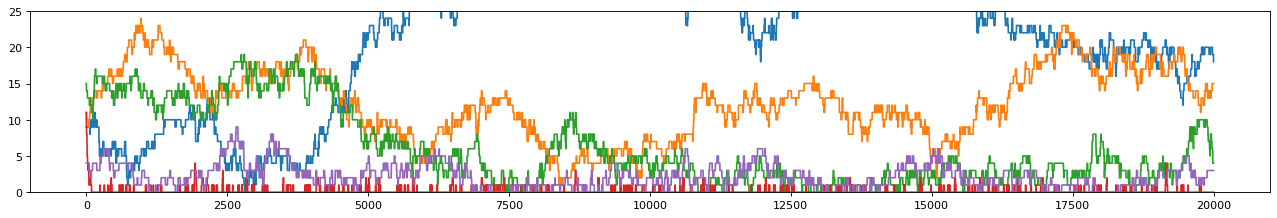

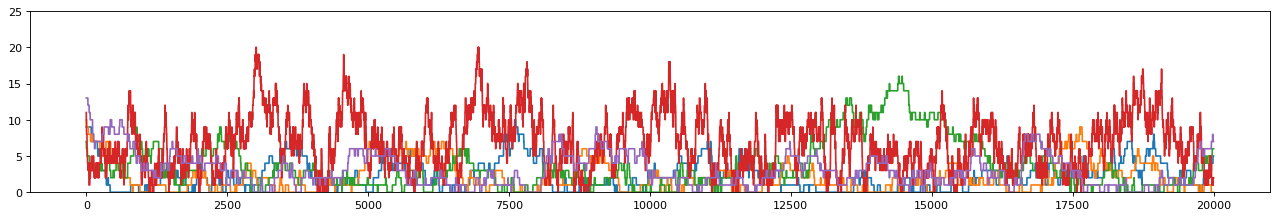

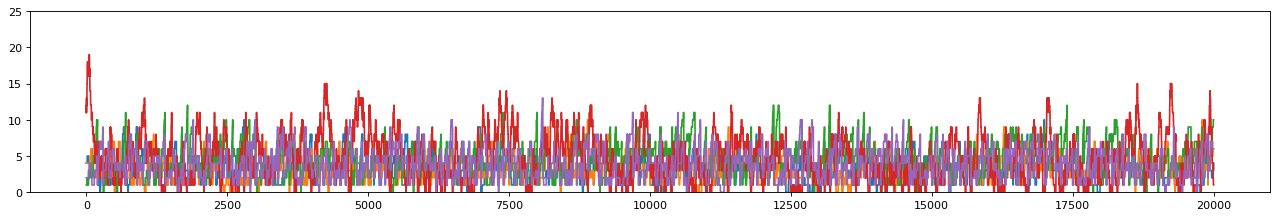

In [12]:
print('optimal number of idle cars:')
print(my_solver.a.value * my_model.N)
print()

figure(num=None, figsize=(20, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.stack(my_simulator_ori_nop.A))
plt.ylim((0, my_N/2))

figure(num=None, figsize=(20, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.stack(my_simulator_ori_sta.A))
plt.ylim((0, my_N/2))

figure(num=None, figsize=(20, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.stack(my_mdp_ori_dep.A))
plt.ylim((0, my_N/2))

optimal number of full cars:
[[ 0.24187  0.06262  0.26535  0.05043  0.0656 ]
 [ 0.05264  0.14238  0.19696  0.02043  0.04021]
 [ 0.38797  0.33611  0.18376  0.66716  0.17452]
 [ 1.62345  0.78184 10.68997  0.24137  0.3868 ]
 [ 0.06898  0.05028  0.09949  0.09275  0.34076]]



(0.0, 25.0)

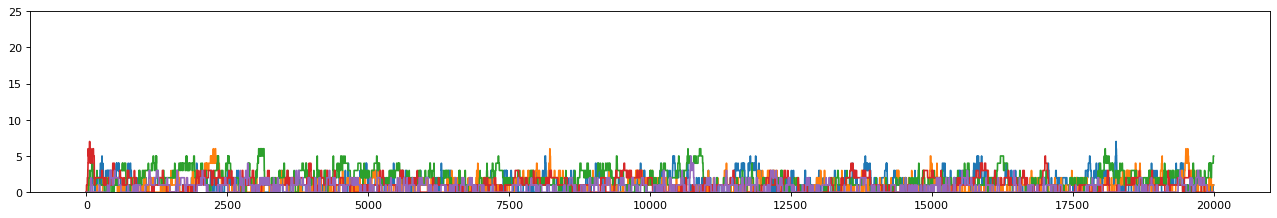

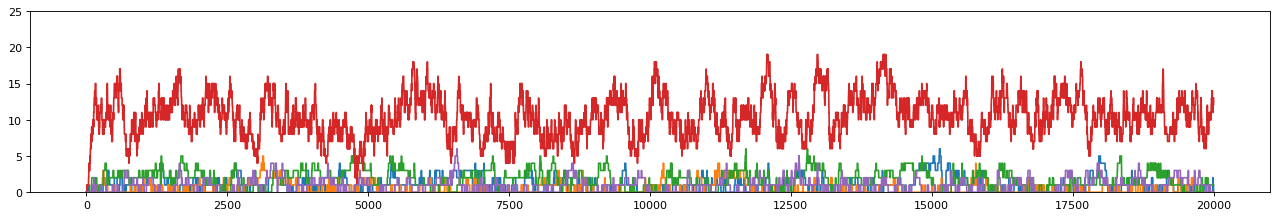

In [13]:
print('optimal number of full cars:')
print(my_solver.f.value * my_model.N)
print()

figure(num=None, figsize=(20, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.sum(np.stack(my_simulator_ori_nop.F), axis=2))
plt.ylim((0, my_N/2))

figure(num=None, figsize=(20, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.sum(np.stack(my_simulator_ori_sta.F), axis=2))
plt.ylim((0, my_N/2))

figure(num=None, figsize=(20, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.sum(np.stack(my_mdp_ori_dep.F), axis=2))
plt.ylim((0, my_N/2))

<br>

## Expanded Network

<br>

In [14]:
# setup networks for simulation
my_model_exp_nop = CTMC(p = my_solver_exp.p_opt.copy(), q = np.diag(np.array([1, 1, 1, 1, 1])), lmd = my_lmd, mu = my_mu, N = my_N, expanded=True)
my_model_exp_sta = CTMC(p = my_solver_exp.p_opt.copy(), q = my_solver_exp.q_opt.copy(), lmd = my_lmd, mu = my_mu, N = my_N, expanded=True)
my_model_exp_dep = CTMC(p = my_solver_exp.p_opt.copy(), q = my_solver_exp.q_opt.copy(), lmd = my_lmd, mu = my_mu, N = my_N, expanded=True)

# setup number of events
my_events = 10000

# run simulation
my_simulator_exp_nop = Simulator(model = my_model_exp_nop, x = my_solver_exp.x_opt, num_events = my_events)
my_simulator_exp_sta = Simulator(model = my_model_exp_sta, x = my_solver_exp.x_opt, num_events = my_events)
my_mdp_exp_dep = ApproxMDP(model = my_model_exp_dep, solver = my_solver_exp, num_events = my_events)

my_simulator_exp_nop.run()
my_simulator_exp_sta.run()
my_mdp_exp_dep.run()

print('optimal (fluid-based) average revenue of the expginal network:')
print(my_solver_exp.revenue.value)
print()

print('simulated average revenue with no repositioning:')
print(my_simulator_exp_nop.avg_revenue)
print()

print('simulated average revenue with static repositioning:')
print(my_simulator_exp_sta.avg_revenue)
print()

print('simulated average revenue with state-dependent repositioning:')
print(my_mdp_exp_dep.avg_revenue)
print()

optimal (fluid-based) average revenue of the expginal network:
14.280416478321047

simulated average revenue with no repositioning:
4.7506258353166775

simulated average revenue with static repositioning:
10.82265462526934

simulated average revenue with state-dependent repositioning:
11.682441130167419



optimal number of idle cars:
[3.31178 2.29249 8.77998 6.84447 4.48888]



(0.0, 25.0)

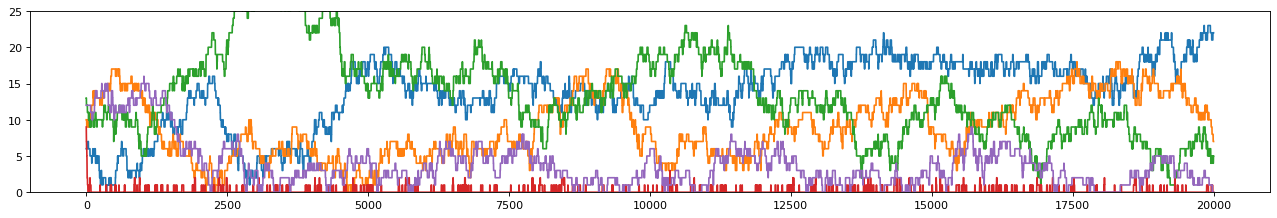

In [15]:
print('optimal number of idle cars:')
print(my_solver.a.value * my_model.N + np.sum(my_solver.e.value * my_model.N, axis=1))
print()

figure(num=None, figsize=(20, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.stack(my_simulator_exp_nop.A) + np.sum(np.stack(my_simulator_exp_nop.E), axis=2))
plt.ylim((0, my_N/2))

figure(num=None, figsize=(20, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.stack(my_simulator_exp_sta.A) + np.sum(np.stack(my_simulator_exp_sta.E), axis=2))
plt.ylim((0, my_N/2))

figure(num=None, figsize=(20, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.stack(my_mdp_exp_dep.A) + np.sum(np.stack(my_mdp_exp_dep.E), axis=2))
plt.ylim((0, my_N/2))

optimal number of full cars:
[[ 0.24187  0.06262  0.26535  0.05043  0.0656 ]
 [ 0.05264  0.14238  0.19696  0.02043  0.04021]
 [ 0.38797  0.33611  0.18376  0.66716  0.17452]
 [ 1.62345  0.78184 10.68997  0.24137  0.3868 ]
 [ 0.06898  0.05028  0.09949  0.09275  0.34076]]



(0.0, 25.0)

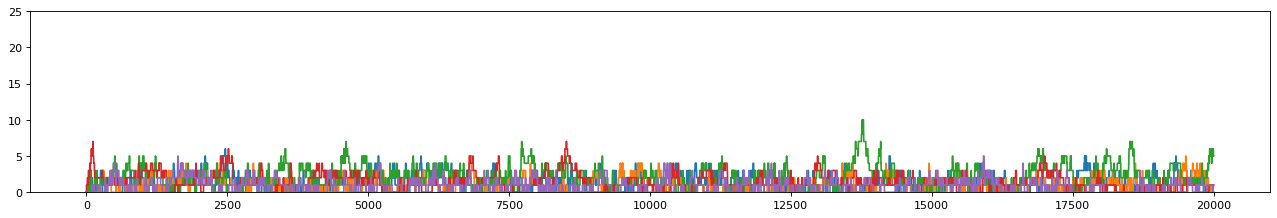

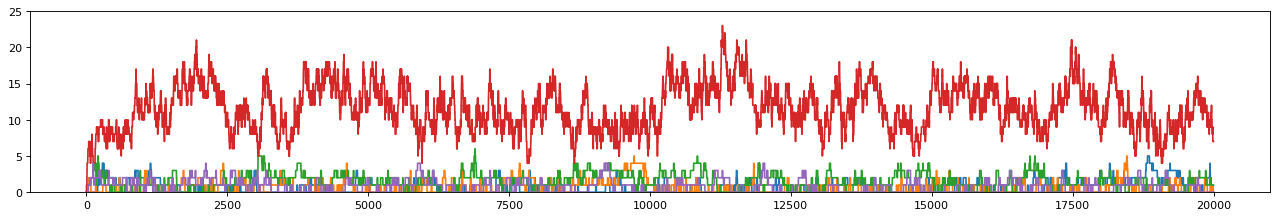

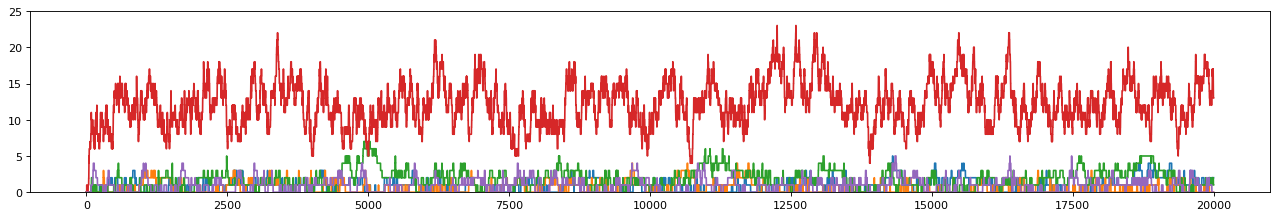

In [16]:
print('optimal number of full cars:')
print(my_solver.f.value * my_model.N)
print()

figure(num=None, figsize=(20, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.sum(np.stack(my_simulator_exp_nop.F), axis=2))
plt.ylim((0, my_N/2))

figure(num=None, figsize=(20, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.sum(np.stack(my_simulator_exp_sta.F), axis=2))
plt.ylim((0, my_N/2))

figure(num=None, figsize=(20, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.sum(np.stack(my_mdp_exp_dep.F), axis=2))
plt.ylim((0, my_N/2))